In [1]:
# Doesnt seem to work
import pandas as pd
import numpy as np
import time

pd.set_option('display.width', 500)

In [2]:
def track_progess(total, progress, text='progress:', inc=1):
    a, b = progress, total
    perc = ((a+1) / b * 100)
    if a%inc == 0:
        print("\r {} {:_}/{:_} ({:.5f}%)".format( text, (a+1), b, perc ), end='')
    a += 1
    return a, perc

In [3]:
class UnionFind:
    def __init__(self, n):
        self.parent = [i for i in range(n)]
        self.rank = [0] * n
        self.size = [1] * n

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]

    def union(self, u, v):
        pu, pv = self.find(u), self.find(v)
        if pu == pv:
            return
        if self.rank[pu] < self.rank[pv]:
            self.parent[pu] = pv
            self.size[pv] += self.size[pu]
        elif self.rank[pv] < self.rank[pu]:
            self.parent[pv] = pu
            self.size[pu] += self.size[pv]
        else:
            self.parent[pu] = pv
            self.rank[pv] += 1
            self.size[pv] += self.size[pu]

In [4]:
def initialize_unionfind(edges):
    print("Initializing UnionFind data structure ...")
    nodes = set(edges['source']).union(set(edges['target']))
    node_index = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)
    uf = UnionFind(n)
    print("Computing union of all edges ...")
    for _, row in edges.iterrows():
        uf.union(node_index[row['source']], node_index[row['target']])
    print("Done.")
    return uf, node_index

In [5]:
def get_connected_component(uf, node_index, n=0):
    comps = {}
    for node, i in node_index.items():
        parent = uf.find(i)
        comps[parent] = comps.get(parent, []) + [node]
    if n >= len(comps):
        return []
    keys_sorted = sorted( comps.keys(), reverse=True, key=lambda parent: len(comps[parent]) )
    return comps[keys_sorted[n]]

In [6]:
def get_amount_of_components(uf, node_index):
    # Count unique parents
    unique_parents = set()
    for i in range(len(node_index)):
        unique_parents.add(uf.find(i))
    return len(unique_parents)

In [7]:
# Read test DF
edges_fn = "../data/edges_test.csv"
# Read edge list to df
df = pd.read_csv(edges_fn)
print("read {:_} lines".format(len(df)))

read 11 lines


In [16]:
# READ REAL DF
edges_fn = "../data/edges.csv"
edges_total = 684_732_453 # hardcoded

# Read edge list to df
perc = 0.1
nrows=int(edges_total*perc/100)
df = pd.read_csv(edges_fn, nrows=nrows)
print("read {:_} lines".format(len(df)))

read 684_732 lines


In [ ]:
# Initialize union find
uf, node_index = initialize_unionfind(df)
# Get nth largest connected component
cc_n = get_amount_of_components(uf, node_index)
print("Found {} connected components:".format(cc_n))
for i in range(cc_n):
    component = get_connected_component(uf, node_index, i)
    print("  component {} has {:_} nodes".format(i+1, len(component)))

In [ ]:
# Get edgelist of connected component
dfcc = df[ (df['source'].isin(component)) & (df['target'].isin(component)) ]
print("{:_} / {:_}".format(len(dfcc), len(df)))

In [ ]:
# Save new edges to file
dfcc.to_csv("../data/edges_cc_test.csv", encoding='utf-8', index=False)

In [17]:
# Get set of all nodes
nodes = set(df['source']).union(set(df['target']))
g = pd.DataFrame(index=list(nodes), columns=['group'])
g['edges'] = np.nan
g['edges'] = g['edges'].apply(lambda x: [])
print("{:_}".format(len(nodes)))
g.head()

3_604


,group,edges
1223990883445440512,NaN,[]
1210026400050102273,NaN,[]
1219608740665622530,NaN,[]
1233841536657391619,NaN,[]
1200999260000419842,NaN,[]


In [18]:
# Generate edges for each
nodes_handled, total = 0, len(nodes)
for node, row in g.iterrows():
    edges = df[(df['source'] == node) | (df['target'] == node)]
    neighbors = set(edges['source']).union(set(edges['target']))
    neighbors.remove(node)
    for n in neighbors:
        g.loc[node, 'edges'].append(n)
    nodes_handled, perc = track_progess(total, nodes_handled, text='progress:', inc=10)
g.head()

 progress: 3_601/3_604 (99.91676%)

,group,edges
1223990883445440512,NaN,"[1200988481075449856, 1201414396175507456, 120..."
1210026400050102273,NaN,"[1200988481075449856, 1201414396175507456, 120..."
1219608740665622530,NaN,"[1204258038665760768, 1200928806757752833, 120..."
1233841536657391619,NaN,"[1211311170025598976, 1200948819015454721, 120..."
1200999260000419842,NaN,"[1201235846084595712, 1200968563617460225, 120..."


In [19]:
# 
current_group = 0
for node, row in g.iterrows():
    if pd.isna(row['group']):
        current_group += 1
        queue = [node]
        while queue != []:
            current = queue.pop(0)
            if pd.isna(g.loc[current, 'group']):
                g.loc[current, 'group'] = current_group
                for nei in g.loc[current, 'edges']:
                    queue.append(nei)
g.head(12)

 progress: 3_601/3_604 (99.91676%)

,group,edges
1223990883445440512,1,"[1200988481075449856, 1201414396175507456, 120..."
1210026400050102273,1,"[1200988481075449856, 1201414396175507456, 120..."
1219608740665622530,3,"[1204258038665760768, 1200928806757752833, 120..."
1233841536657391619,1,"[1211311170025598976, 1200948819015454721, 120..."
1200999260000419842,5,"[1201235846084595712, 1200968563617460225, 120..."
1226161512689041413,1,"[1211311170025598976, 1200948819015454721, 120..."
1233768237009076229,1,"[1211311170025598976, 1200948819015454721, 120..."
1211509858425438213,1,"[1200988481075449856, 1201414396175507456, 120..."
1227804762973798406,1,"[1211311170025598976, 1200948819015454721, 120..."
1222555375980838918,10,"[1200982015933214720, 1204247272449462272, 121..."


In [20]:
n = set(g['group'])
print(n)

{1, 67, 3, 5, 10, 819, 181}


Graph with 12 nodes and 11 edges


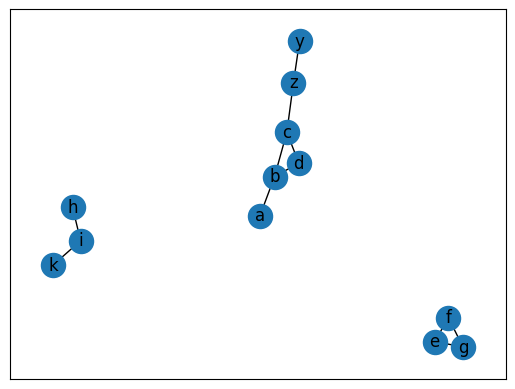

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
g = nx.from_pandas_edgelist(df, source='source', target='target')
print(g)
nx.draw_networkx(g)
plt.show()